# Cadastre

Example montrant comment créer une géométrie sur la plateforme Oplus à partir de
données du cadastre.

Vous pouvez lancer ce notebook dans google colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openergy/oplusclient/blob/master/samples/cadastre.ipynb)

## Installation et import des dépendances

In [9]:
!pip install oplusclient geopandas shapely matplotlib descartes

You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [28]:
import geopandas as pd
import shapely
import requests
import io
import gzip
from oplusclient.tools import geo_data_frame_to_floorplan
from oplusclient import Client
%matplotlib inline

## Récupération des données de cadastre de la commune

Changer lat et lon pour la latitude et longitude d'un point à l'intérieur du bâtiment. (à récupérer sur google maps par exemple)

Ville: Paris


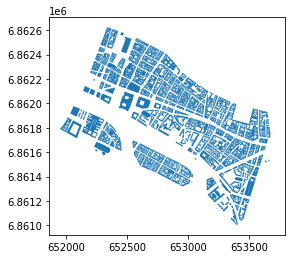

In [14]:
lat, lon = 48.860506, 2.352529
coords = [lon, lat]
resp = requests.get(f"https://geo.api.gouv.fr/communes?lon={lon}&lat={lat}").json()
if len(resp) == 0:
    raise ValueError("Ces coordonnées ne sont pas dans une commune française.")
print(f"Ville: {resp[0]['nom']}")
code_commune = resp[0]["code"]
if code_commune == "75056":
    arr = int(input("Pour Paris, veuillez donner le numéro d'arrondissement: "))
    code_commune = str(75100 + arr)
elif code_commune == "69123":
    arr = int(input("Pour Lyon, veuillez donner le numéro d'arrondissement: "))
    code_commune = str(69380 + arr)
elif code_commune == "13055":
    arr = int(input("Pour Marseille, veuillez donner le numéro d'arrondissement: "))
    code_commune = str(13200 + arr)
df = pd.read_file(io.BytesIO(gzip.decompress(requests.get(
    f"https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/{code_commune}/geojson-gz/batiments"
).content)))
df.to_crs(epsg=2154).plot()

## Restriction aux bâtiments environnents

La variable `e` permet de déterminer dans quel périmètre on va récupérer les bâtiments alentour (pour faire des shadings).

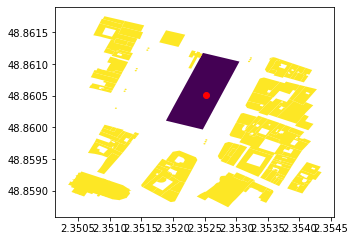

In [21]:
e = 0.0015
point = shapely.geometry.Point(coords)
surroundings_df = df.cx[coords[0] - e: coords[0] + e, coords[1] - e: coords[1] + e]
surroundings_df = surroundings_df.copy()
surroundings_df["shading"] = surroundings_df.geometry.map(lambda x: not point.within(x))
base = surroundings_df.plot("shading", figsize = (5,5))
pd.GeoDataFrame(geometry=pd.points_from_xy([lon], [lat])).plot(ax=base, color='r')

## Export vers oplus

### Génération du floorplan

In [26]:
floorplan_str = geo_data_frame_to_floorplan(surroundings_df)

### Ajout dans la plateforme

Modifier les variables organization_name, project_name, et geometry_name de manière appropriée
(Le token demandé peut être récupéré [ici](https://oplus-back.openergy.fr/api/v1/oteams/users/me/api_token).

Le projet doit avoir été créé au préalable.

In [32]:
organization_name = "Openergy"
project_name = "demo-floorplan"
geometry_name = "Pompidou"

client = Client()
orga = client.get_organization(organization_name)
orga.take_seat()
project = orga.get_project(project_name)
geometry = project.create_geometry(geometry_name, "floorspace")
geometry.import_file(io.StringIO(floorplan_str))
orga.leave_seat()
print("La géométrie a été créée avec succès dans Oplus.")

